In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Defaults

# System settings
systmpfs = '/tmp'

# Optimizer settings
num_workers = 2
budget = 16
algorithm = 'OnePlusOne'
timeout = 60

In [3]:
import os
import tempfile
import subprocess

from concurrent import futures

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
sns.set(rc={'figure.figsize': (15, 10), 'figure.dpi' : 250})

import nevergrad as ng
import geotopy as gtp

In [4]:
class GEOtopCalibrationRun(gtp.GEOtop):

    def preprocess(self, working_dir, *args, **kwargs):

        settings = {**self.settings, **kwargs}
        
        geotop_inpts_path = os.path.join(working_dir, 'geotop.inpts')
        os.remove(geotop_inpts_path)
        with open(geotop_inpts_path, 'w') as geotop_inpts:
            geotop_inpts.write("! GEOtop input file written by GEOtoPy\n")
            for key, value in settings.items():
                geotop_inpts.write(gtp.print_setting(key, value))    
        
    def postprocess(self, working_dir):
        
        liq_path = os.path.join(working_dir, 'theta_liq.txt')
        liq = pd.read_csv(liq_path, na_values=['-9999'],
                          usecols=[0, 6, 7, 8], 
                          skiprows=1,
                          header=0, 
                          names=["date", 20, 50, 200],
                          parse_dates=True, 
                          infer_datetime_format=True,
                          index_col=0)
        
        ice_path = os.path.join(working_dir, 'theta_ice.txt')
        ice = pd.read_csv(ice_path, na_values=['-9999'], 
                          usecols=[0, 6, 7, 8], 
                          skiprows=1,
                          header=0, 
                          names=["date", 20, 50, 200],
                          parse_dates=True, 
                          infer_datetime_format=True,
                          index_col=0)
        
        sim = ice + liq
        
        obs_path = os.path.join(working_dir, 'obs.csv')
        obs = pd.read_csv(obs_path, 
                          usecols=[0, 6, 7, 8], 
                          header=0, 
                          names=["date", 20, 50, 200], 
                          na_values=['-9999'], 
                          parse_dates=True, 
                          infer_datetime_format=True,
                          index_col=0)
        obs = obs
        
        return obs, sim

    
def diff_metric(obs, sim):
    
    diff = (obs - sim)
    diff_squared = diff * diff
    obs_squared = obs * obs
    
    return np.sqrt(diff_squared.mean().sum() / obs_squared.mean().sum())

In [5]:
def compare(observations, simulation, periods=None, name=None, unit=None, cum=False, rel=False):
    
    if not periods:
        periods = {'Daily': 'D', 'Weekly': 'W', 'Monthly': 'M'}
    
    fig, axes = plt.subplots(ncols=3, 
                             nrows=len(periods), 
                             constrained_layout=True)
    
    if name:
        fig.suptitle(name)
    
    for i, (Tstr, T) in enumerate(periods.items()):
        comp_plot, diff_plot, hist_plot = axes[i, :]
        
        if cum:
            obs_resampled = observations.resample(T).sum()
            sim_resampled = simulation.resample(T).sum()
        else:
            obs_resampled = observations.resample(T).mean()
            sim_resampled = simulation.resample(T).mean()
        
        err = obs_resampled - sim_resampled        
        if rel:
            err = err / obs_resampled.abs()
        
        data = pd.DataFrame({'Observations': obs_resampled, 'Simulation': sim_resampled})
        sns.lineplot(data=data, ax=comp_plot)
        comp_plot.set_title(Tstr)
        comp_plot.set_xlabel("")
        if unit:
            comp_plot.set_ylabel(f'[{unit}]')
        
        sns.lineplot(data=err, ax=diff_plot)
        plt.setp(diff_plot.get_xticklabels(), rotation=20)
        if rel:
            diff_plot.set_ylabel(f'Relative error')
            diff_plot.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
        elif unit:
            diff_plot.set_ylabel(f'Error [{unit}]')
        else:
            diff_plot.set_ylabel(f'Error')
        
        sns.distplot(err, rug=True, vertical=True, hist=True, ax=hist_plot)
        y1, y2 = diff_plot.get_ylim()
        hist_plot.set_ylim(y1,y2)
        hist_plot.set_yticklabels([])
        hist_plot.set_ylabel("")
    return fig

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


Before optimization loss is: 0.5052915147802689


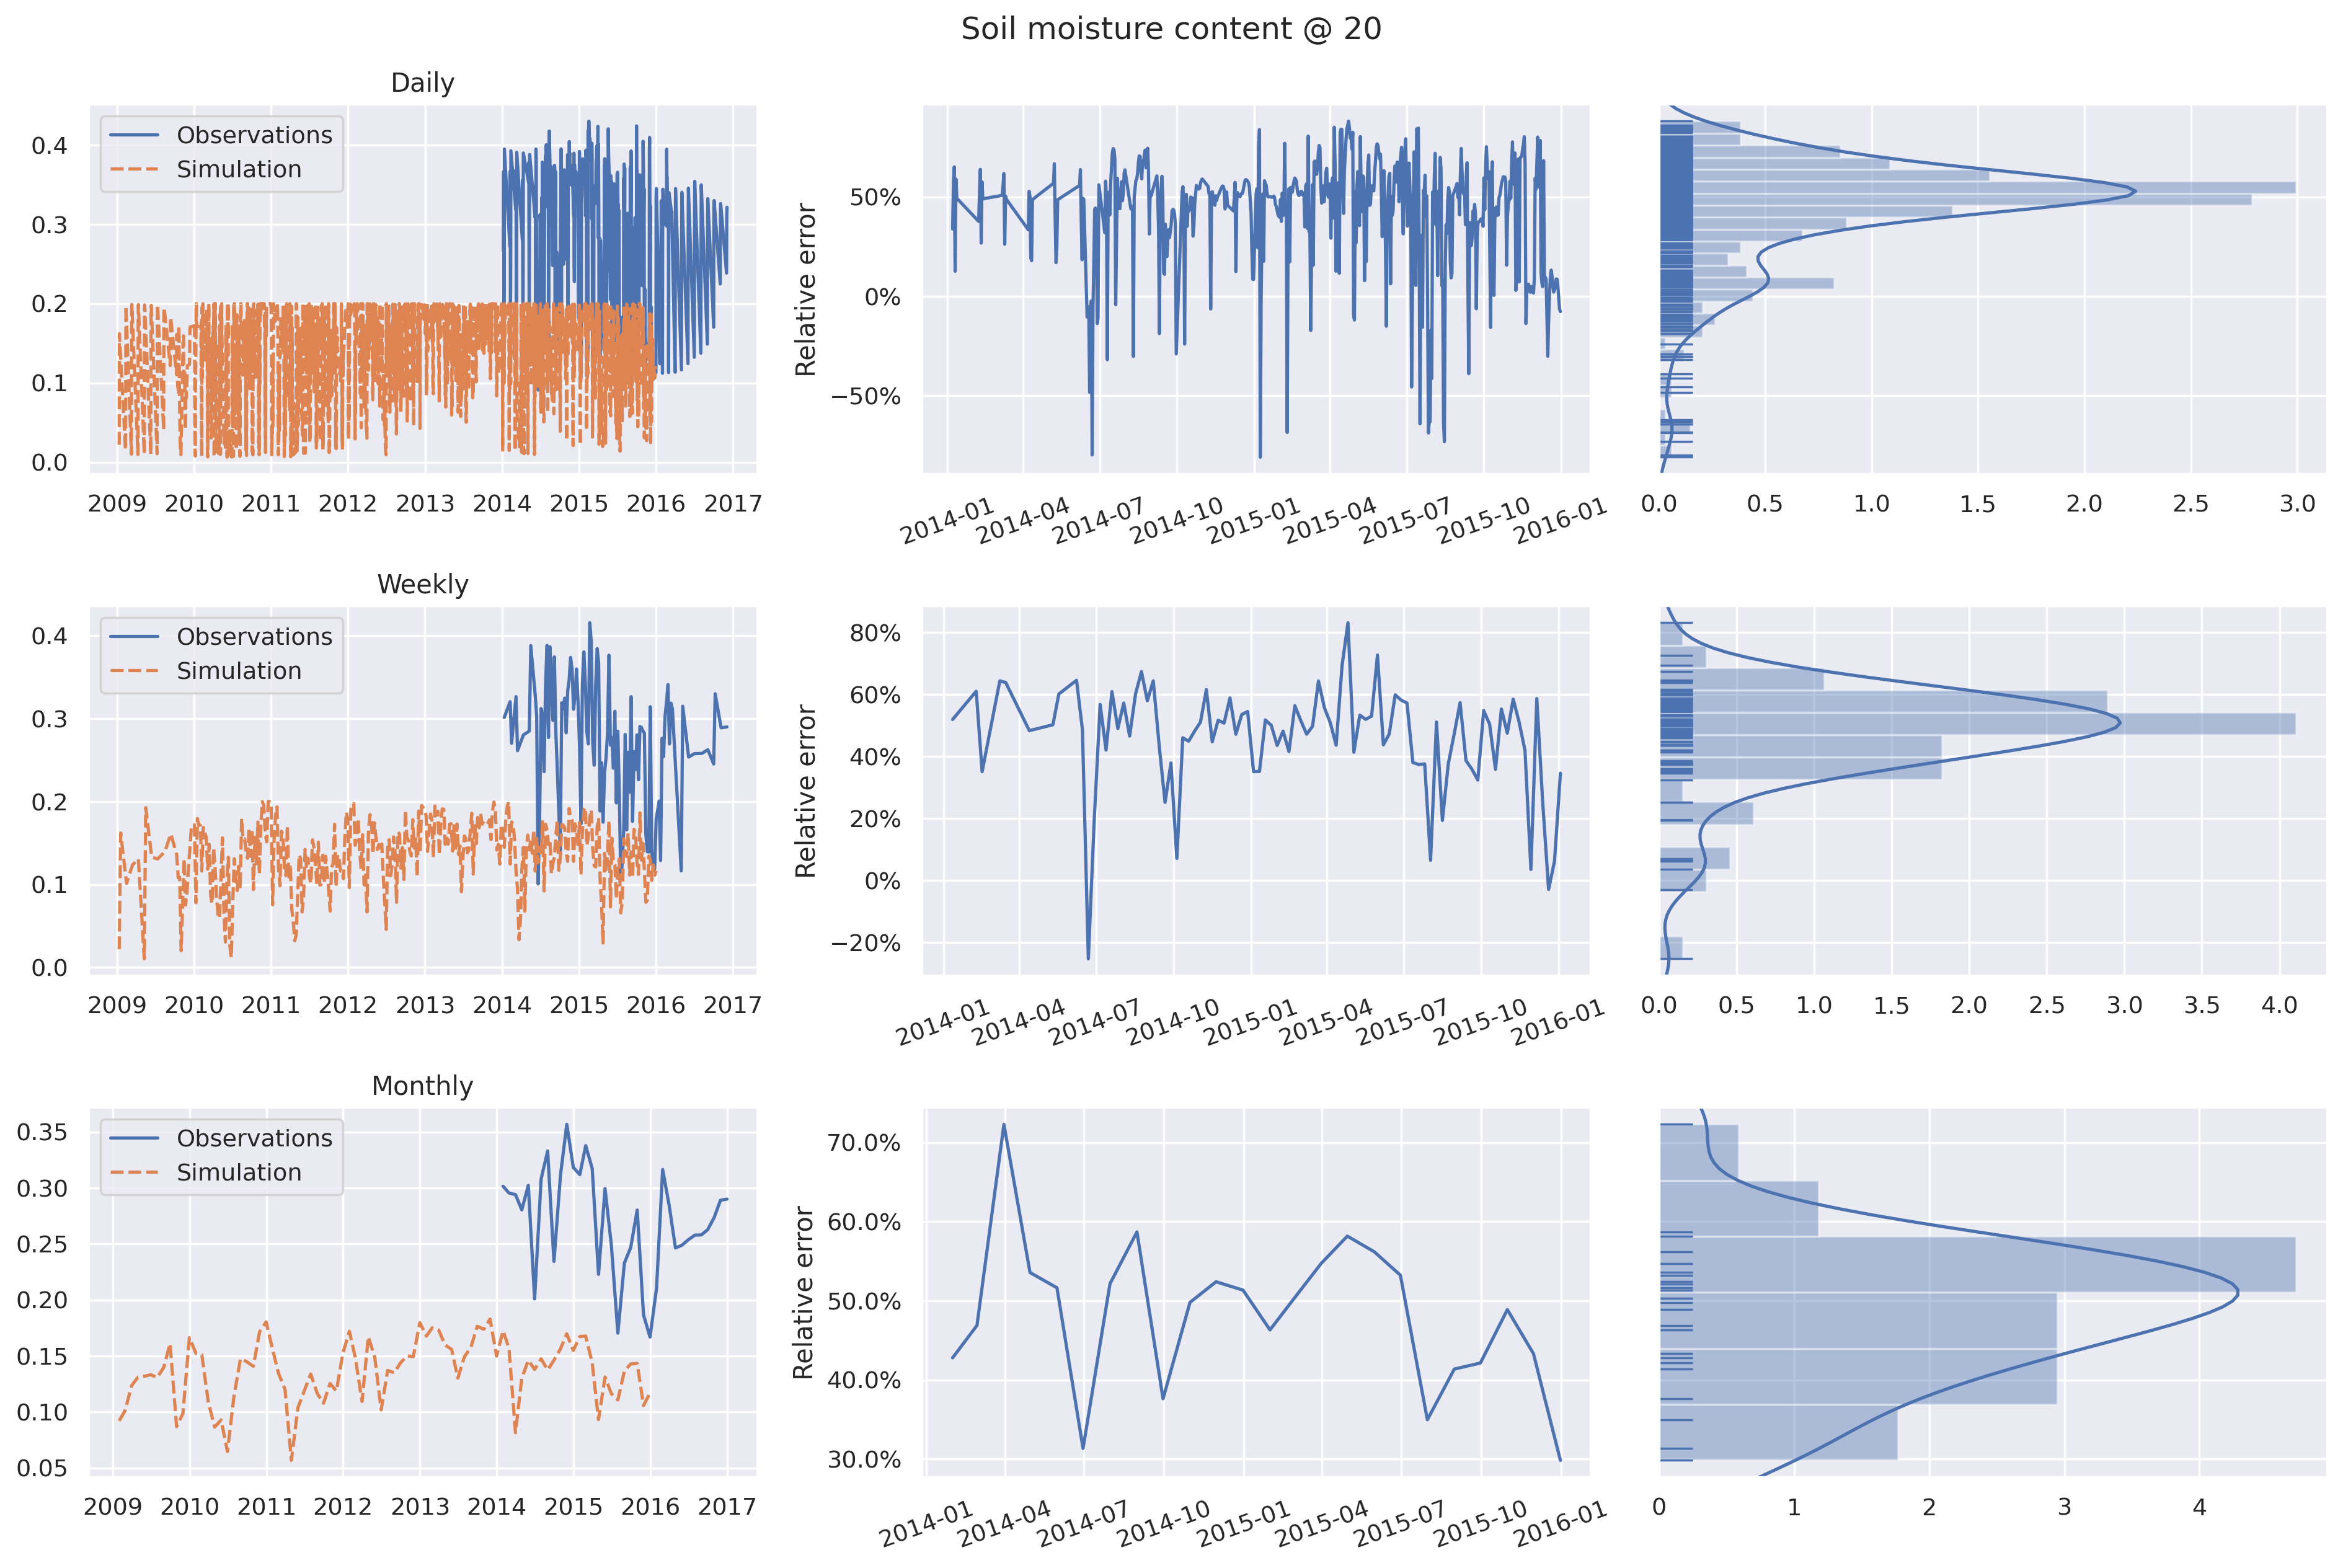

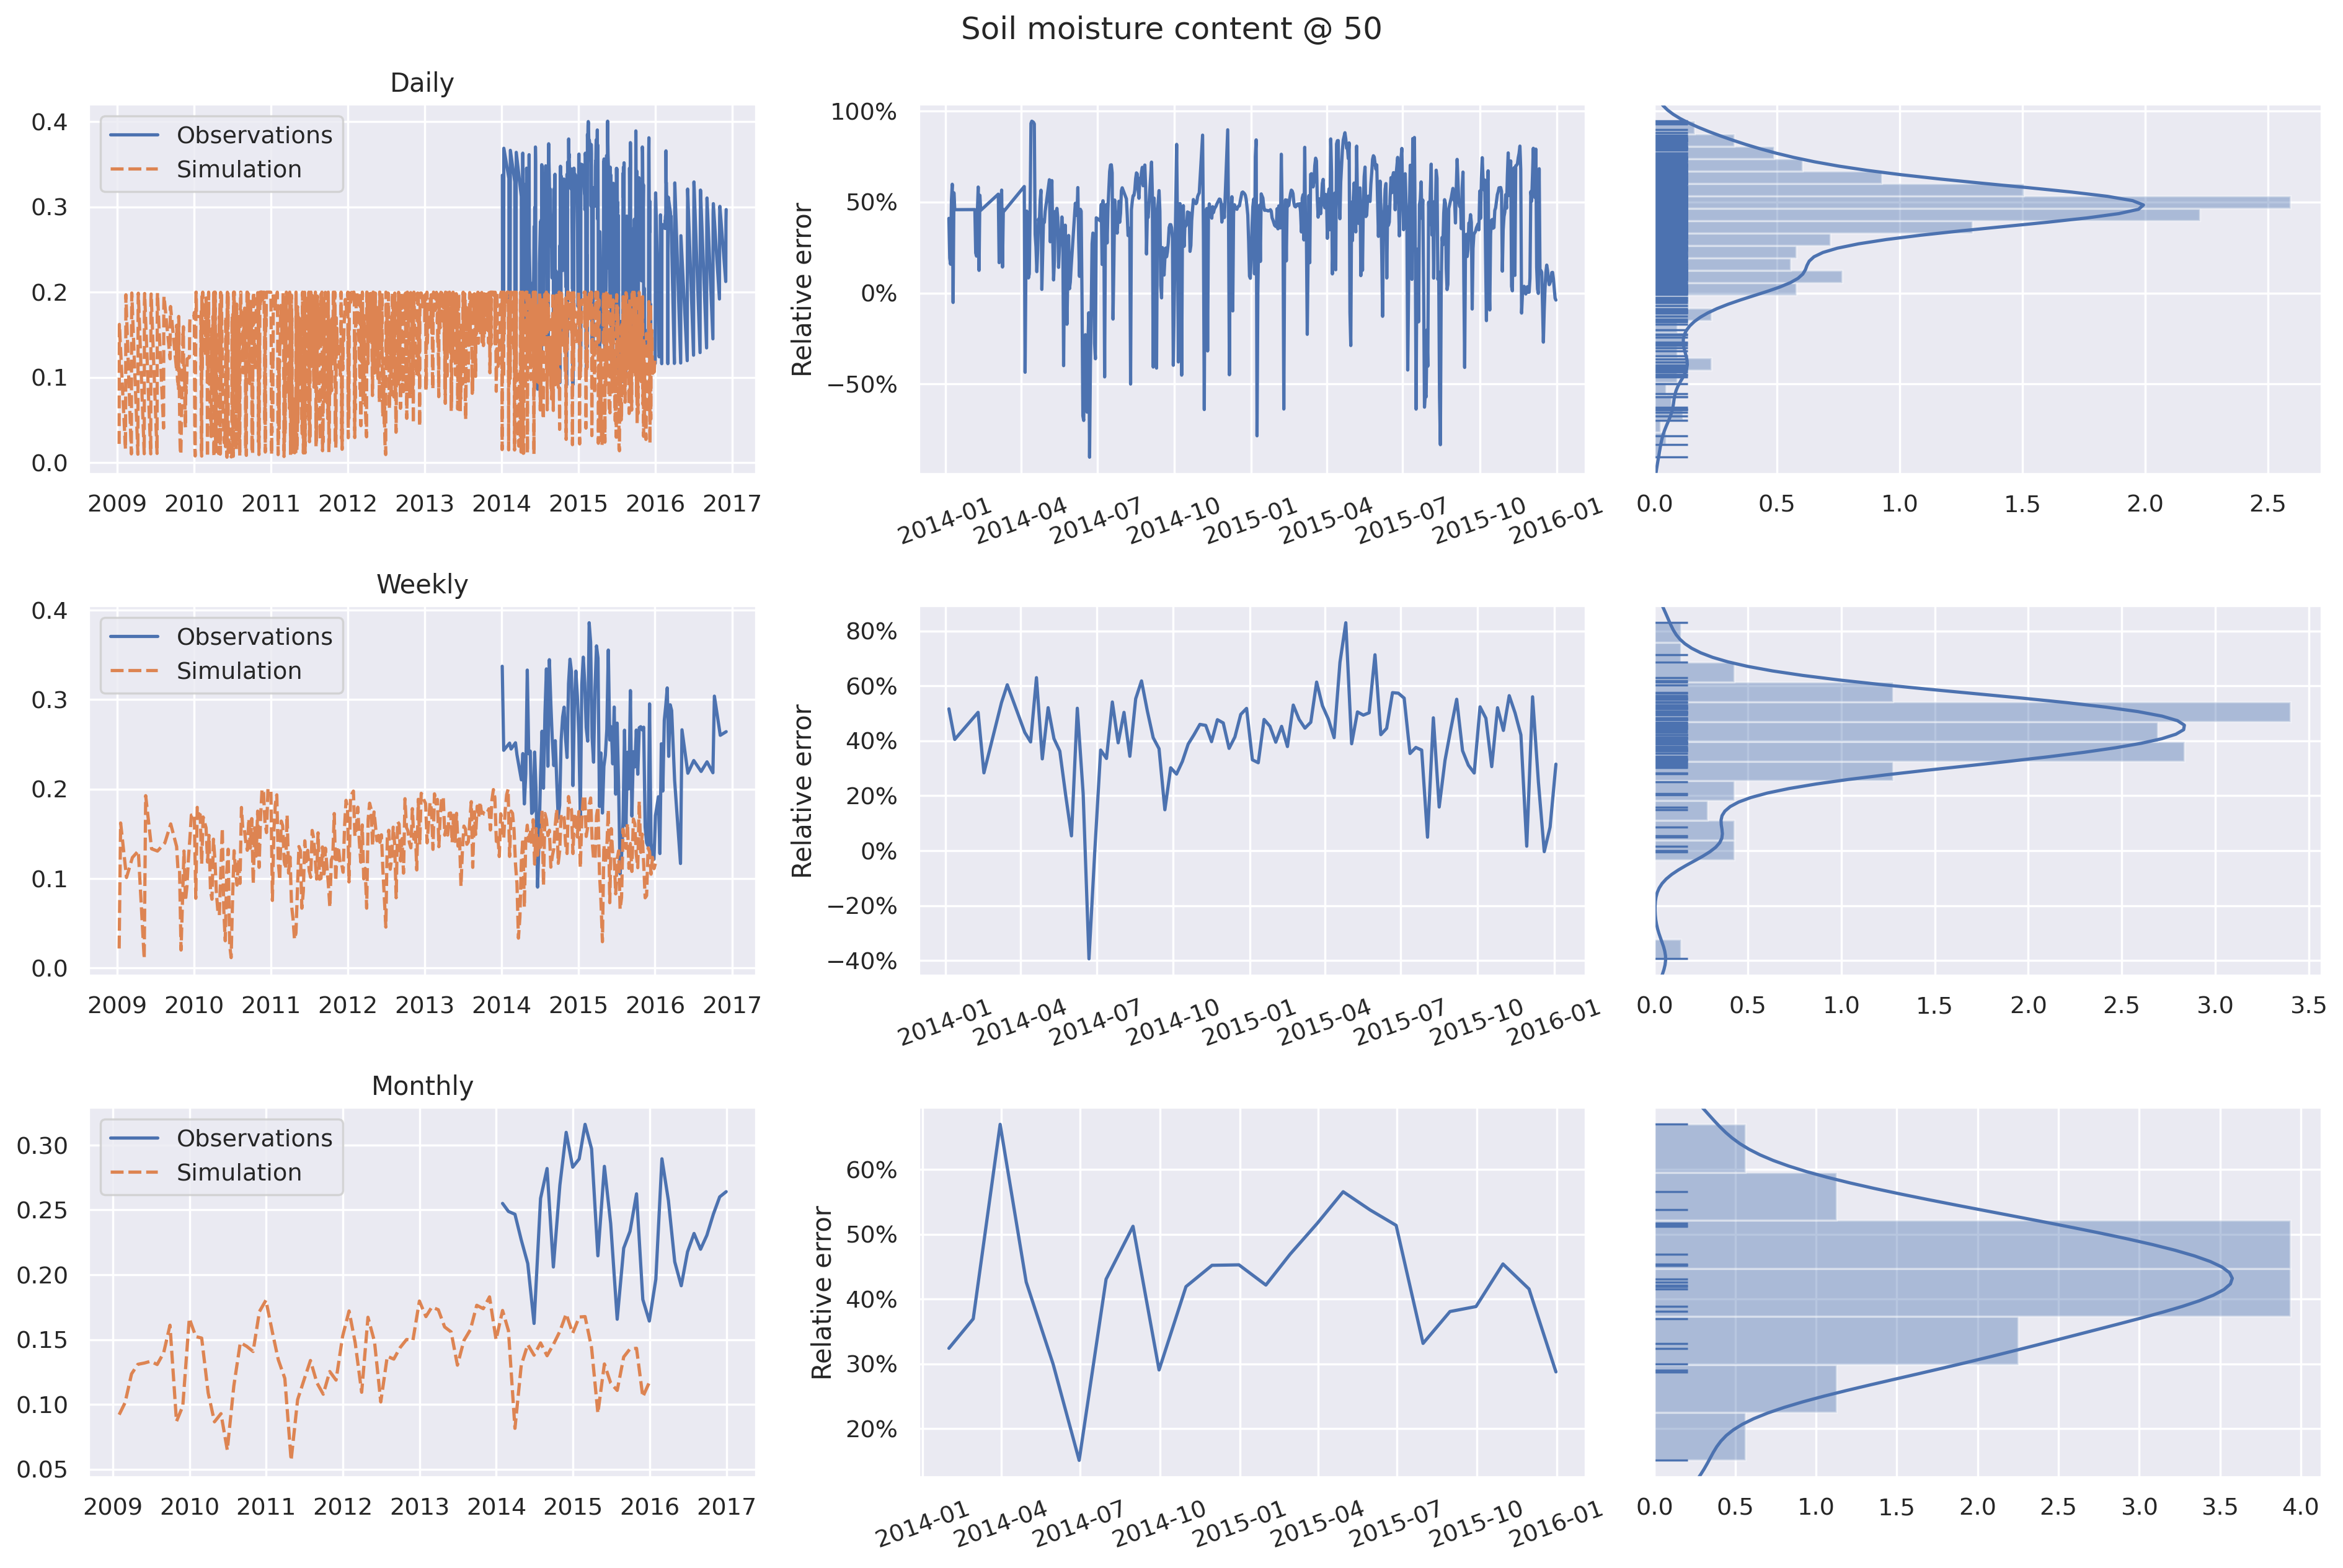

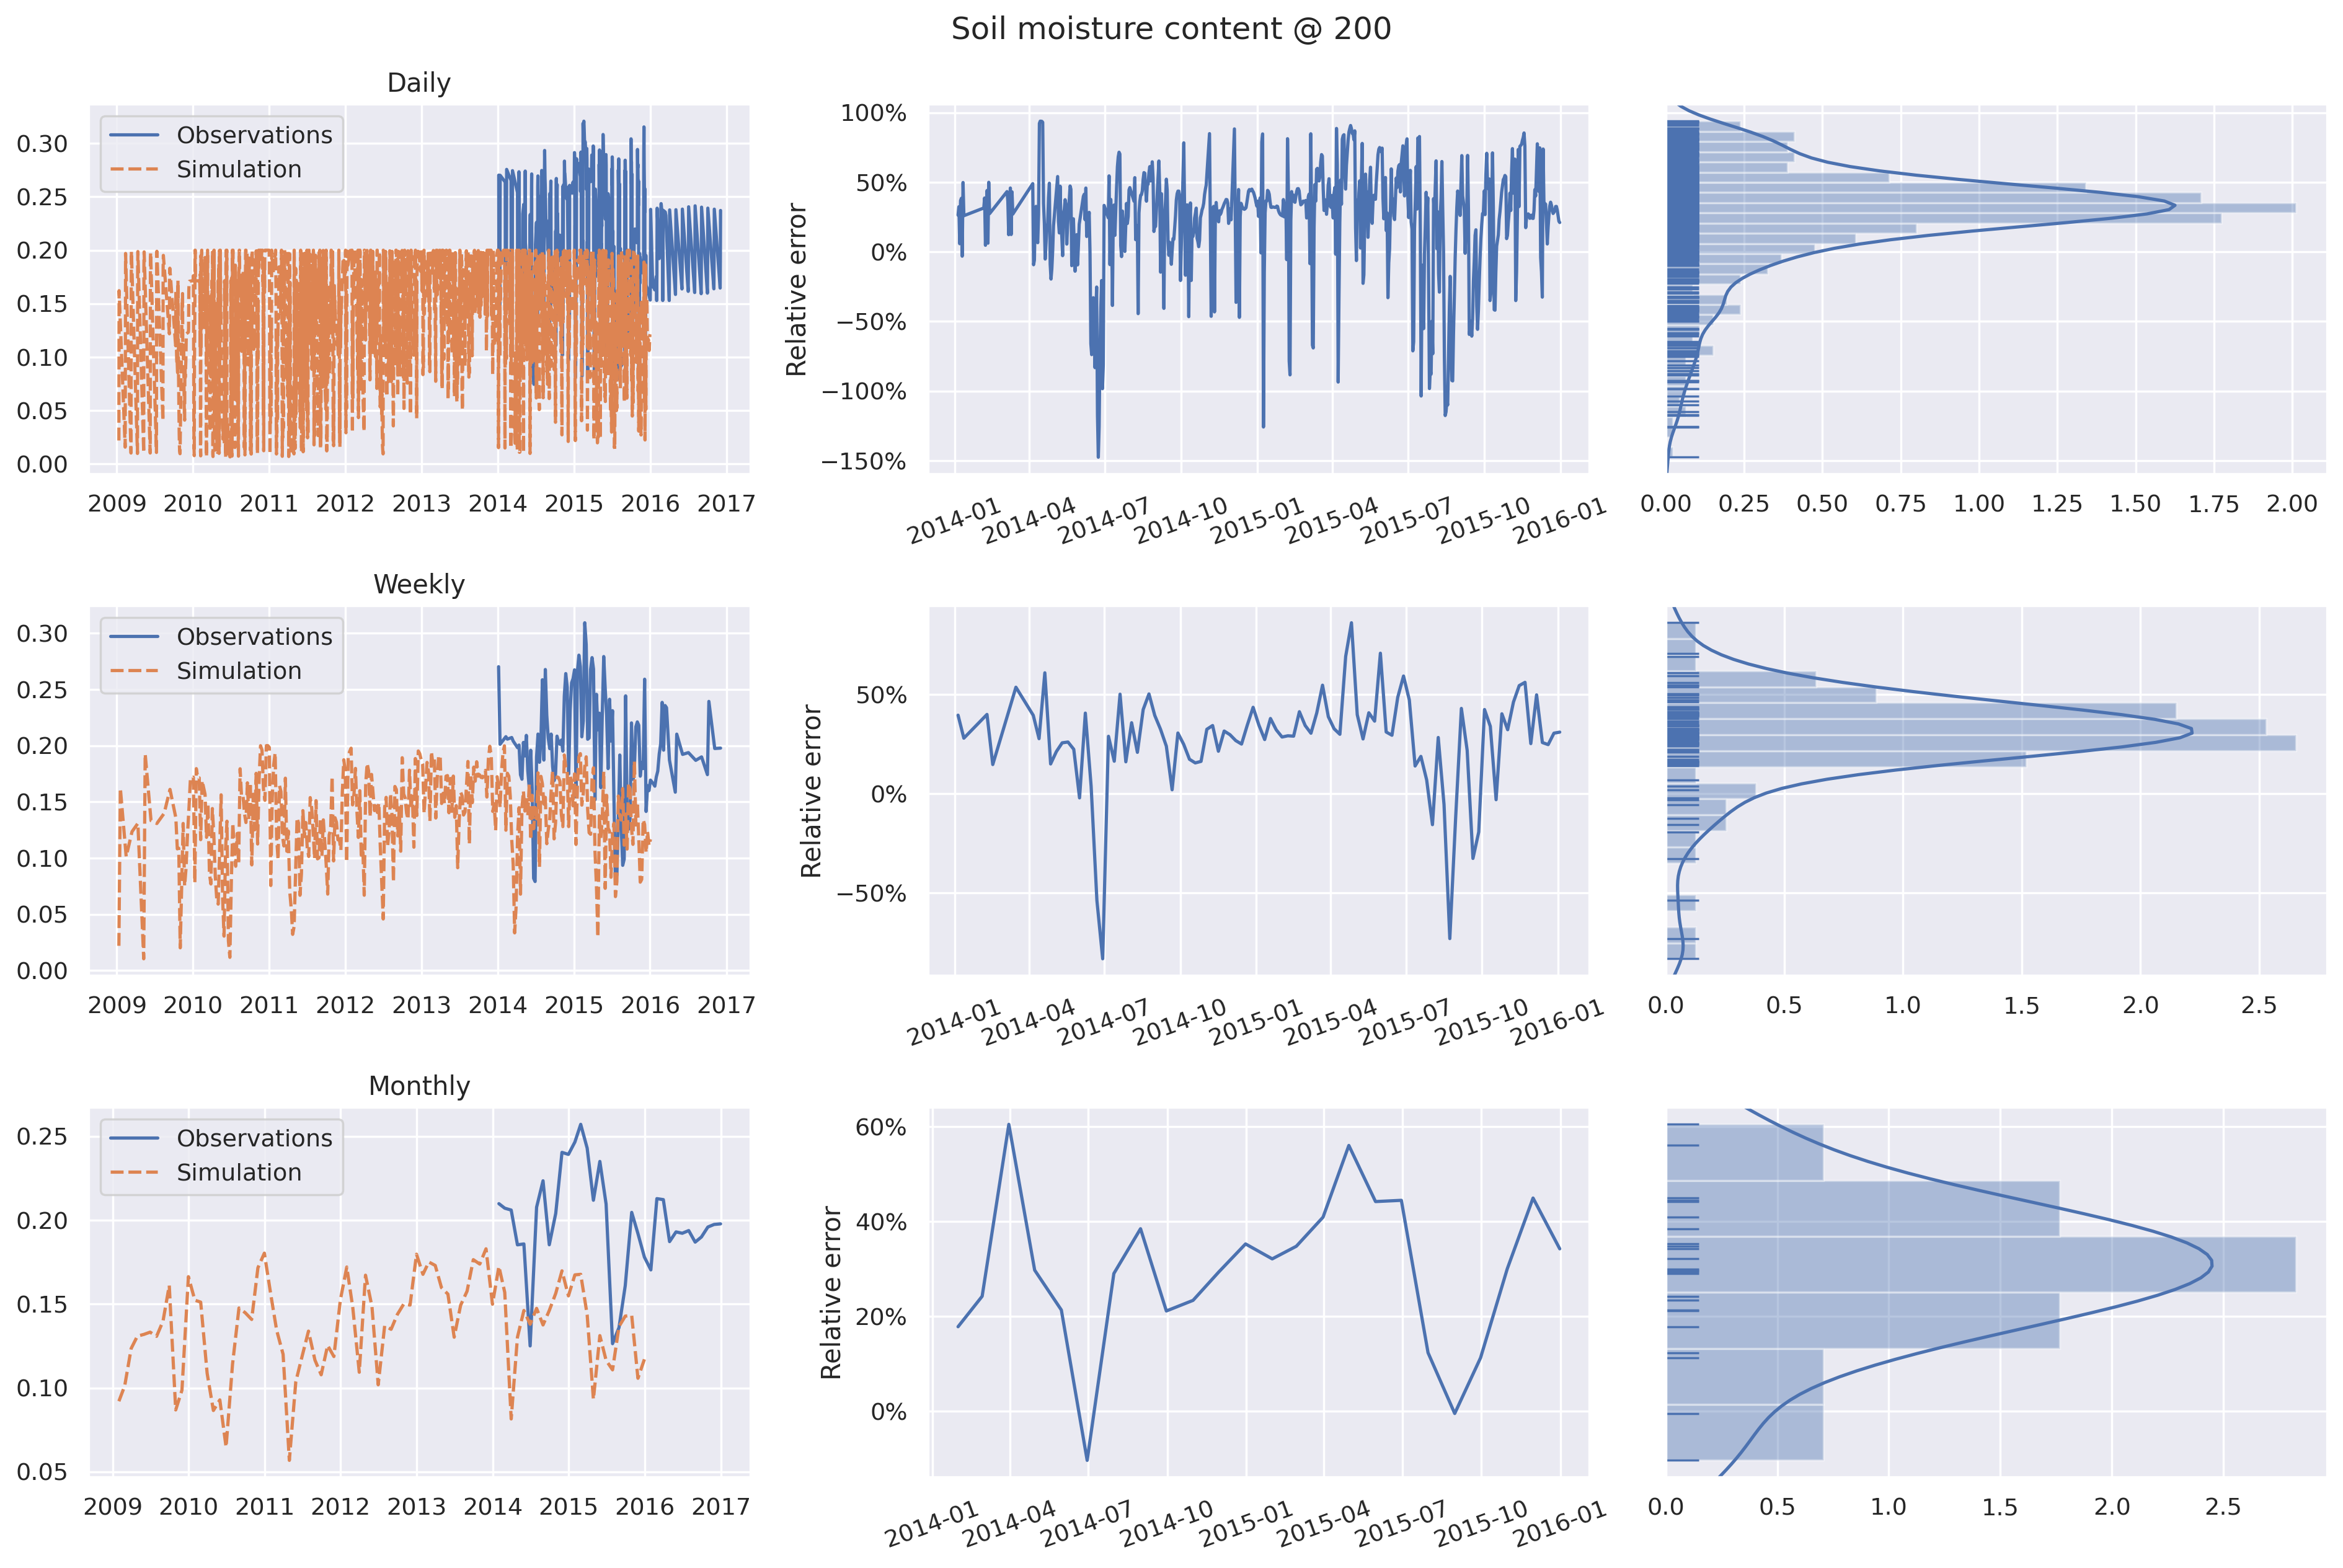

In [6]:
with tempfile.TemporaryDirectory() as tmpdir:
    
    model = GEOtopCalibrationRun('data/inputs', exe='../../geotop/build/geotop')
    obs, sim = model.eval(tmpdir)
    
    print(f"Before optimization loss is: {diff_metric(obs, sim)}")
    
    for depth in [20, 50, 200]:
        compare(obs[depth], sim[depth], name=f"Soil moisture content @ {depth}", rel=True)
        plt.show()

In [7]:
def loss_function(*args, **kwargs):
    
    model = GEOtopCalibrationRun('data/inputs', 
                                 exe='../../geotop/build/geotop',
                                 run_args={'check': True, 'capture_output': True, 'timeout': timeout})
    
    with tempfile.TemporaryDirectory(dir=systmpfs) as tmpdir:
        try:
            output = model.eval(tmpdir, *args, **kwargs)
        except subprocess.CalledProcessError:
            return np.Inf
        except subprocess.TimeoutExpired:
            return np.Inf
    
    return diff_metric(*output)

parameters = ng.p.Instrumentation(LSAI=ng.p.Scalar(lower=20.0, upper=400.0))
optimizer = ng.optimizers.registry[algorithm](parametrization=parameters, budget=budget, num_workers=num_workers)

In [8]:
with futures.ProcessPoolExecutor(max_workers=optimizer.num_workers) as executor:
    recommendation = optimizer.minimize(loss_function, executor=executor, batch_mode=False)

Recommended value is: ((), {'LSAI': 400.0})
Reported loss is: 0.5052915147802689


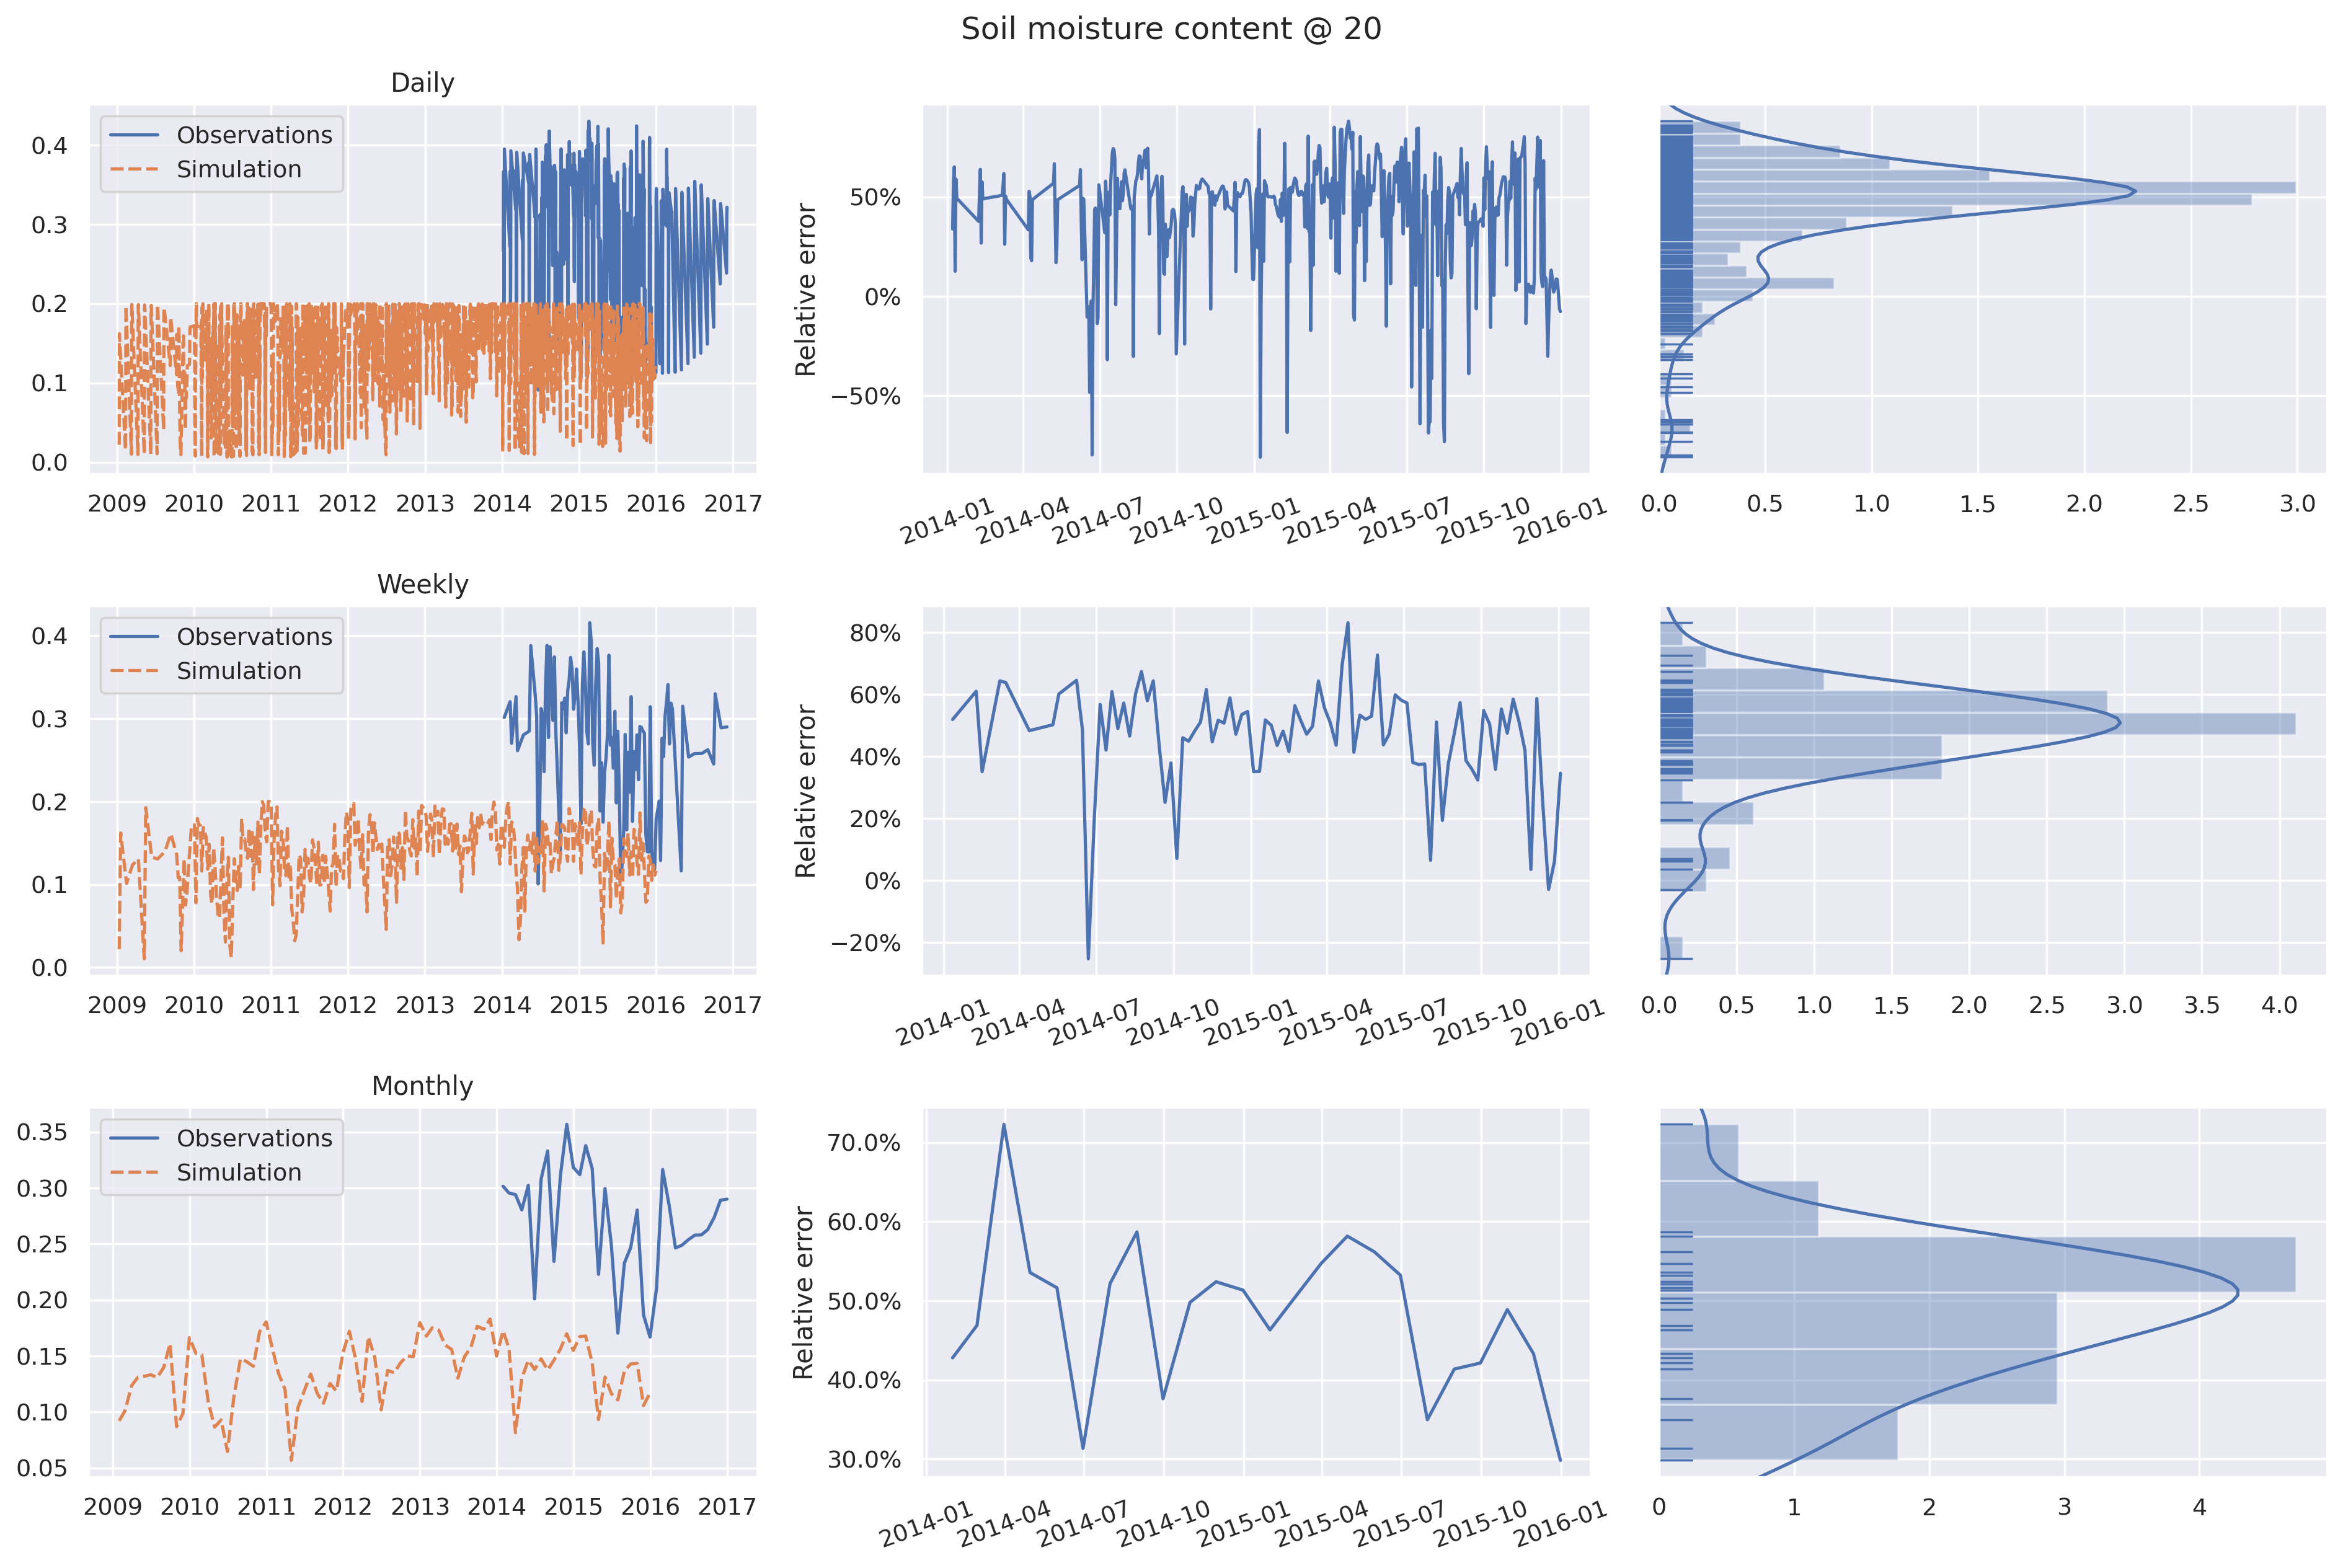

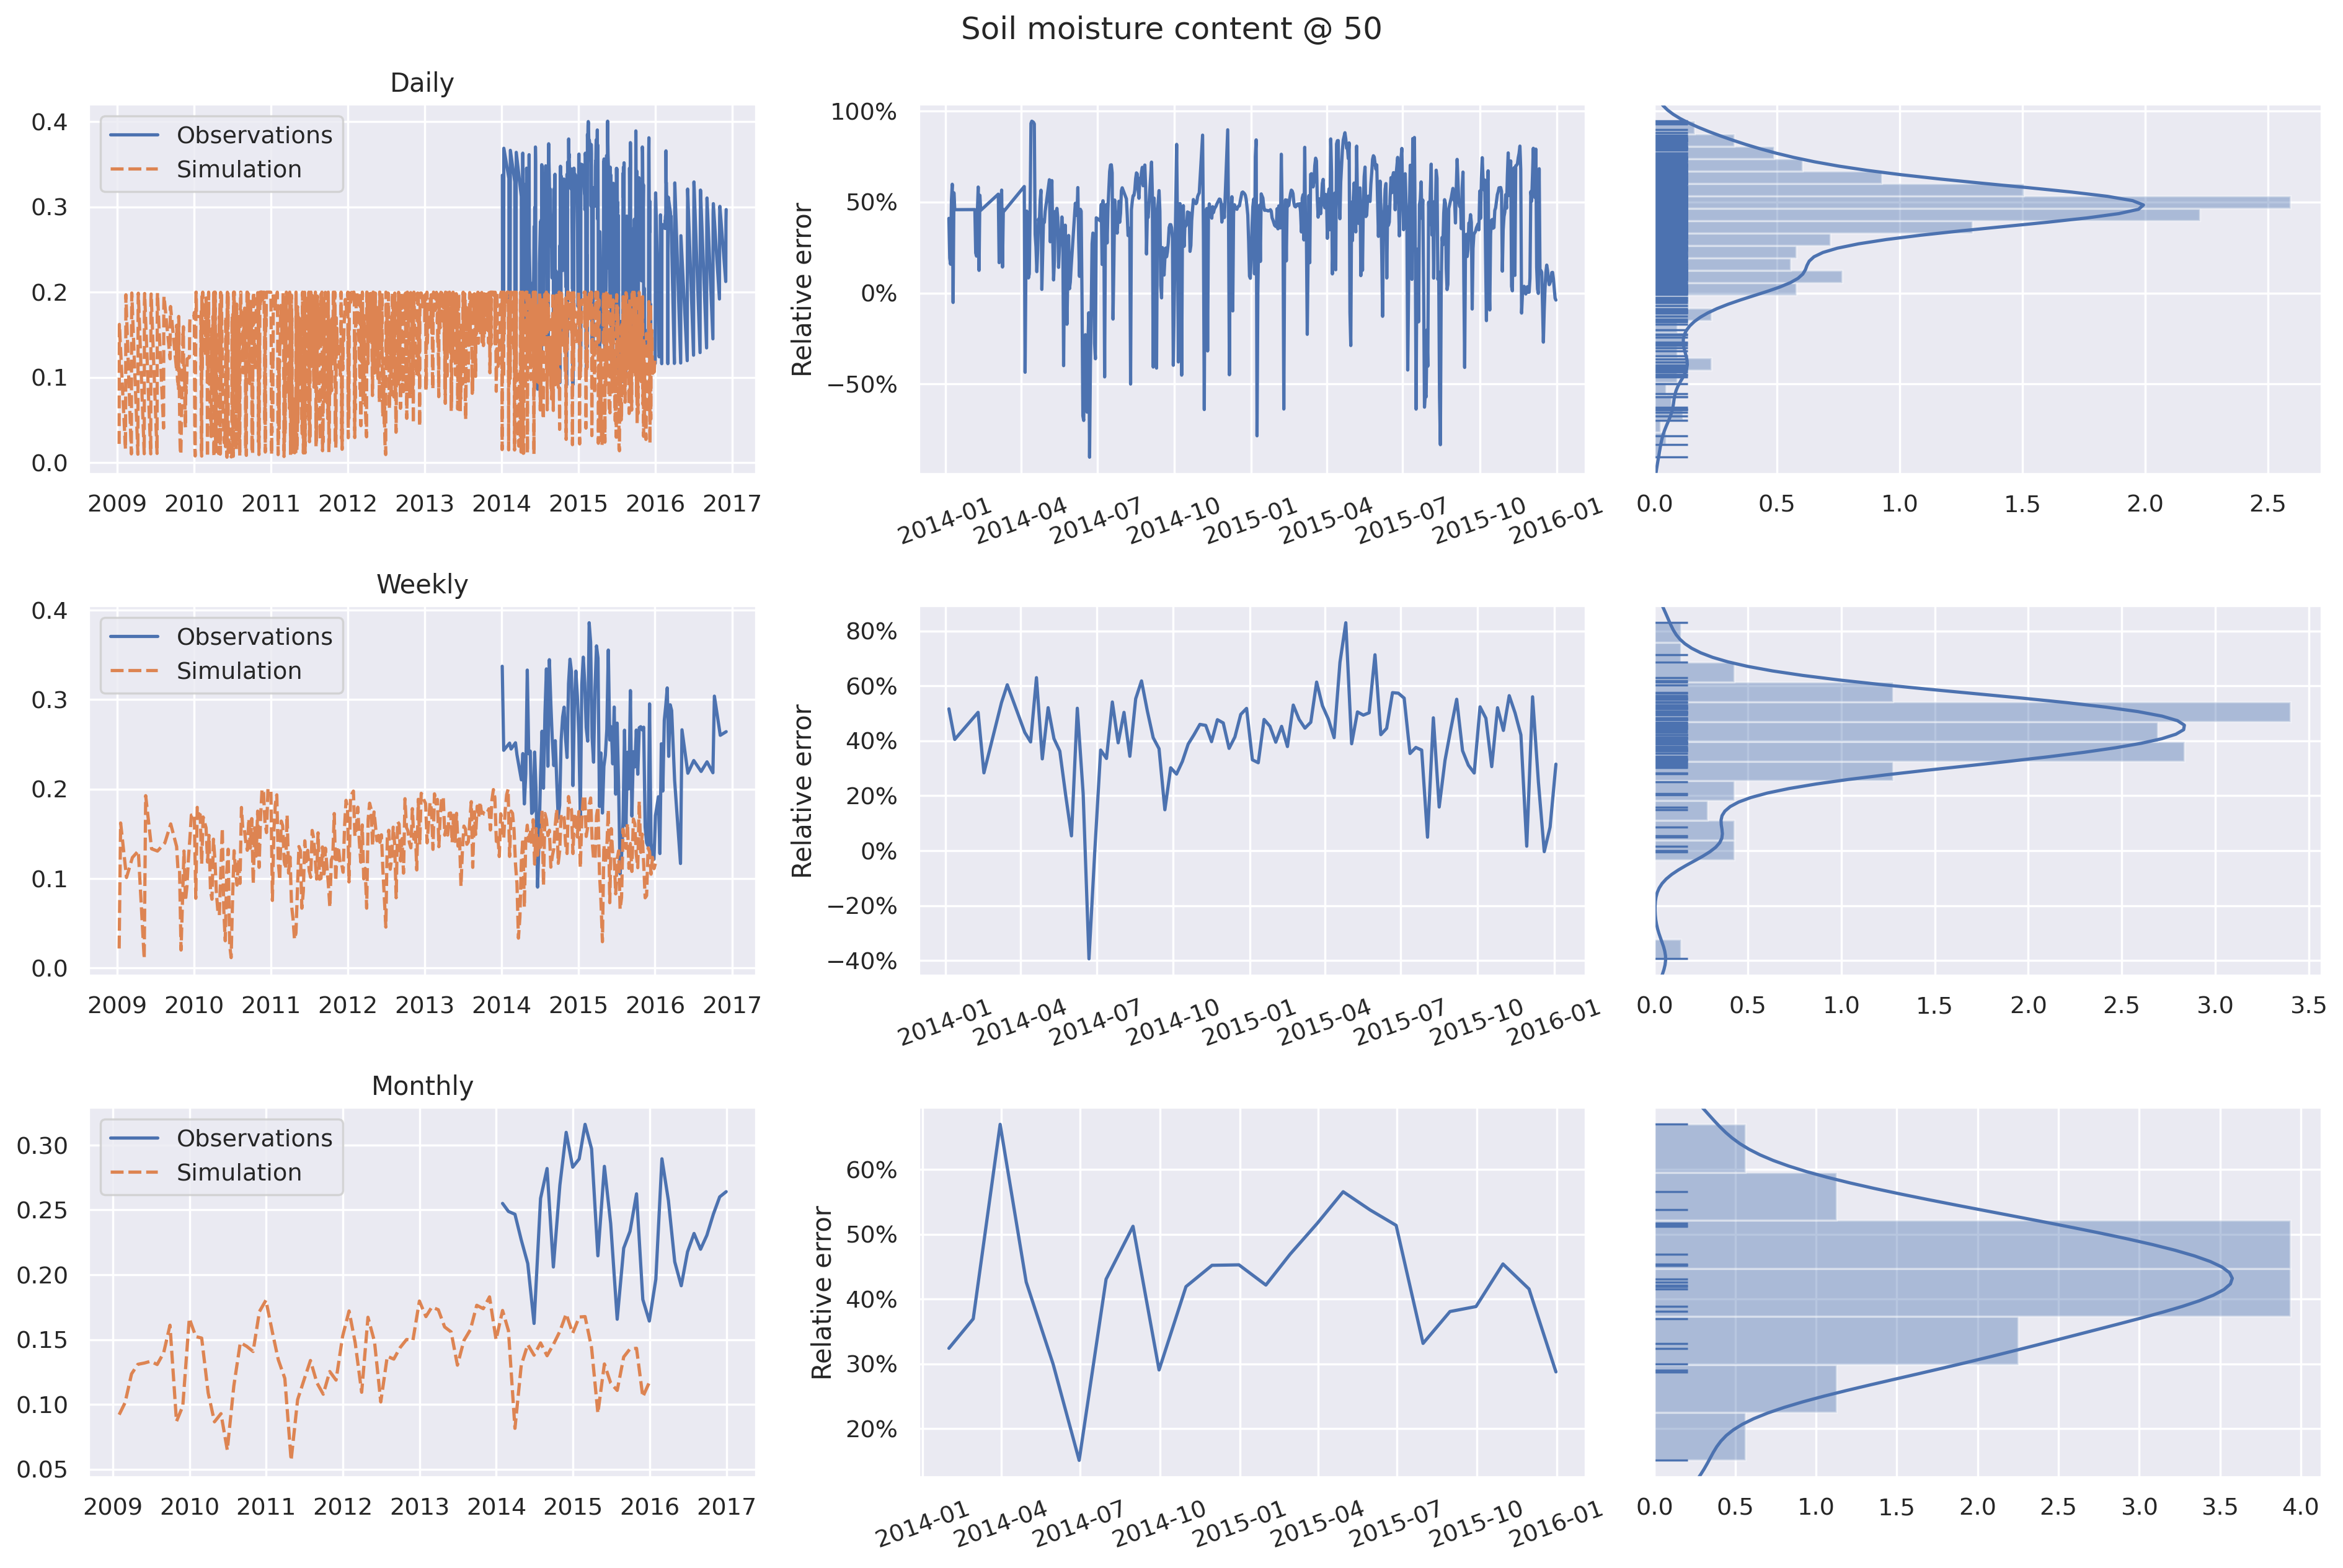

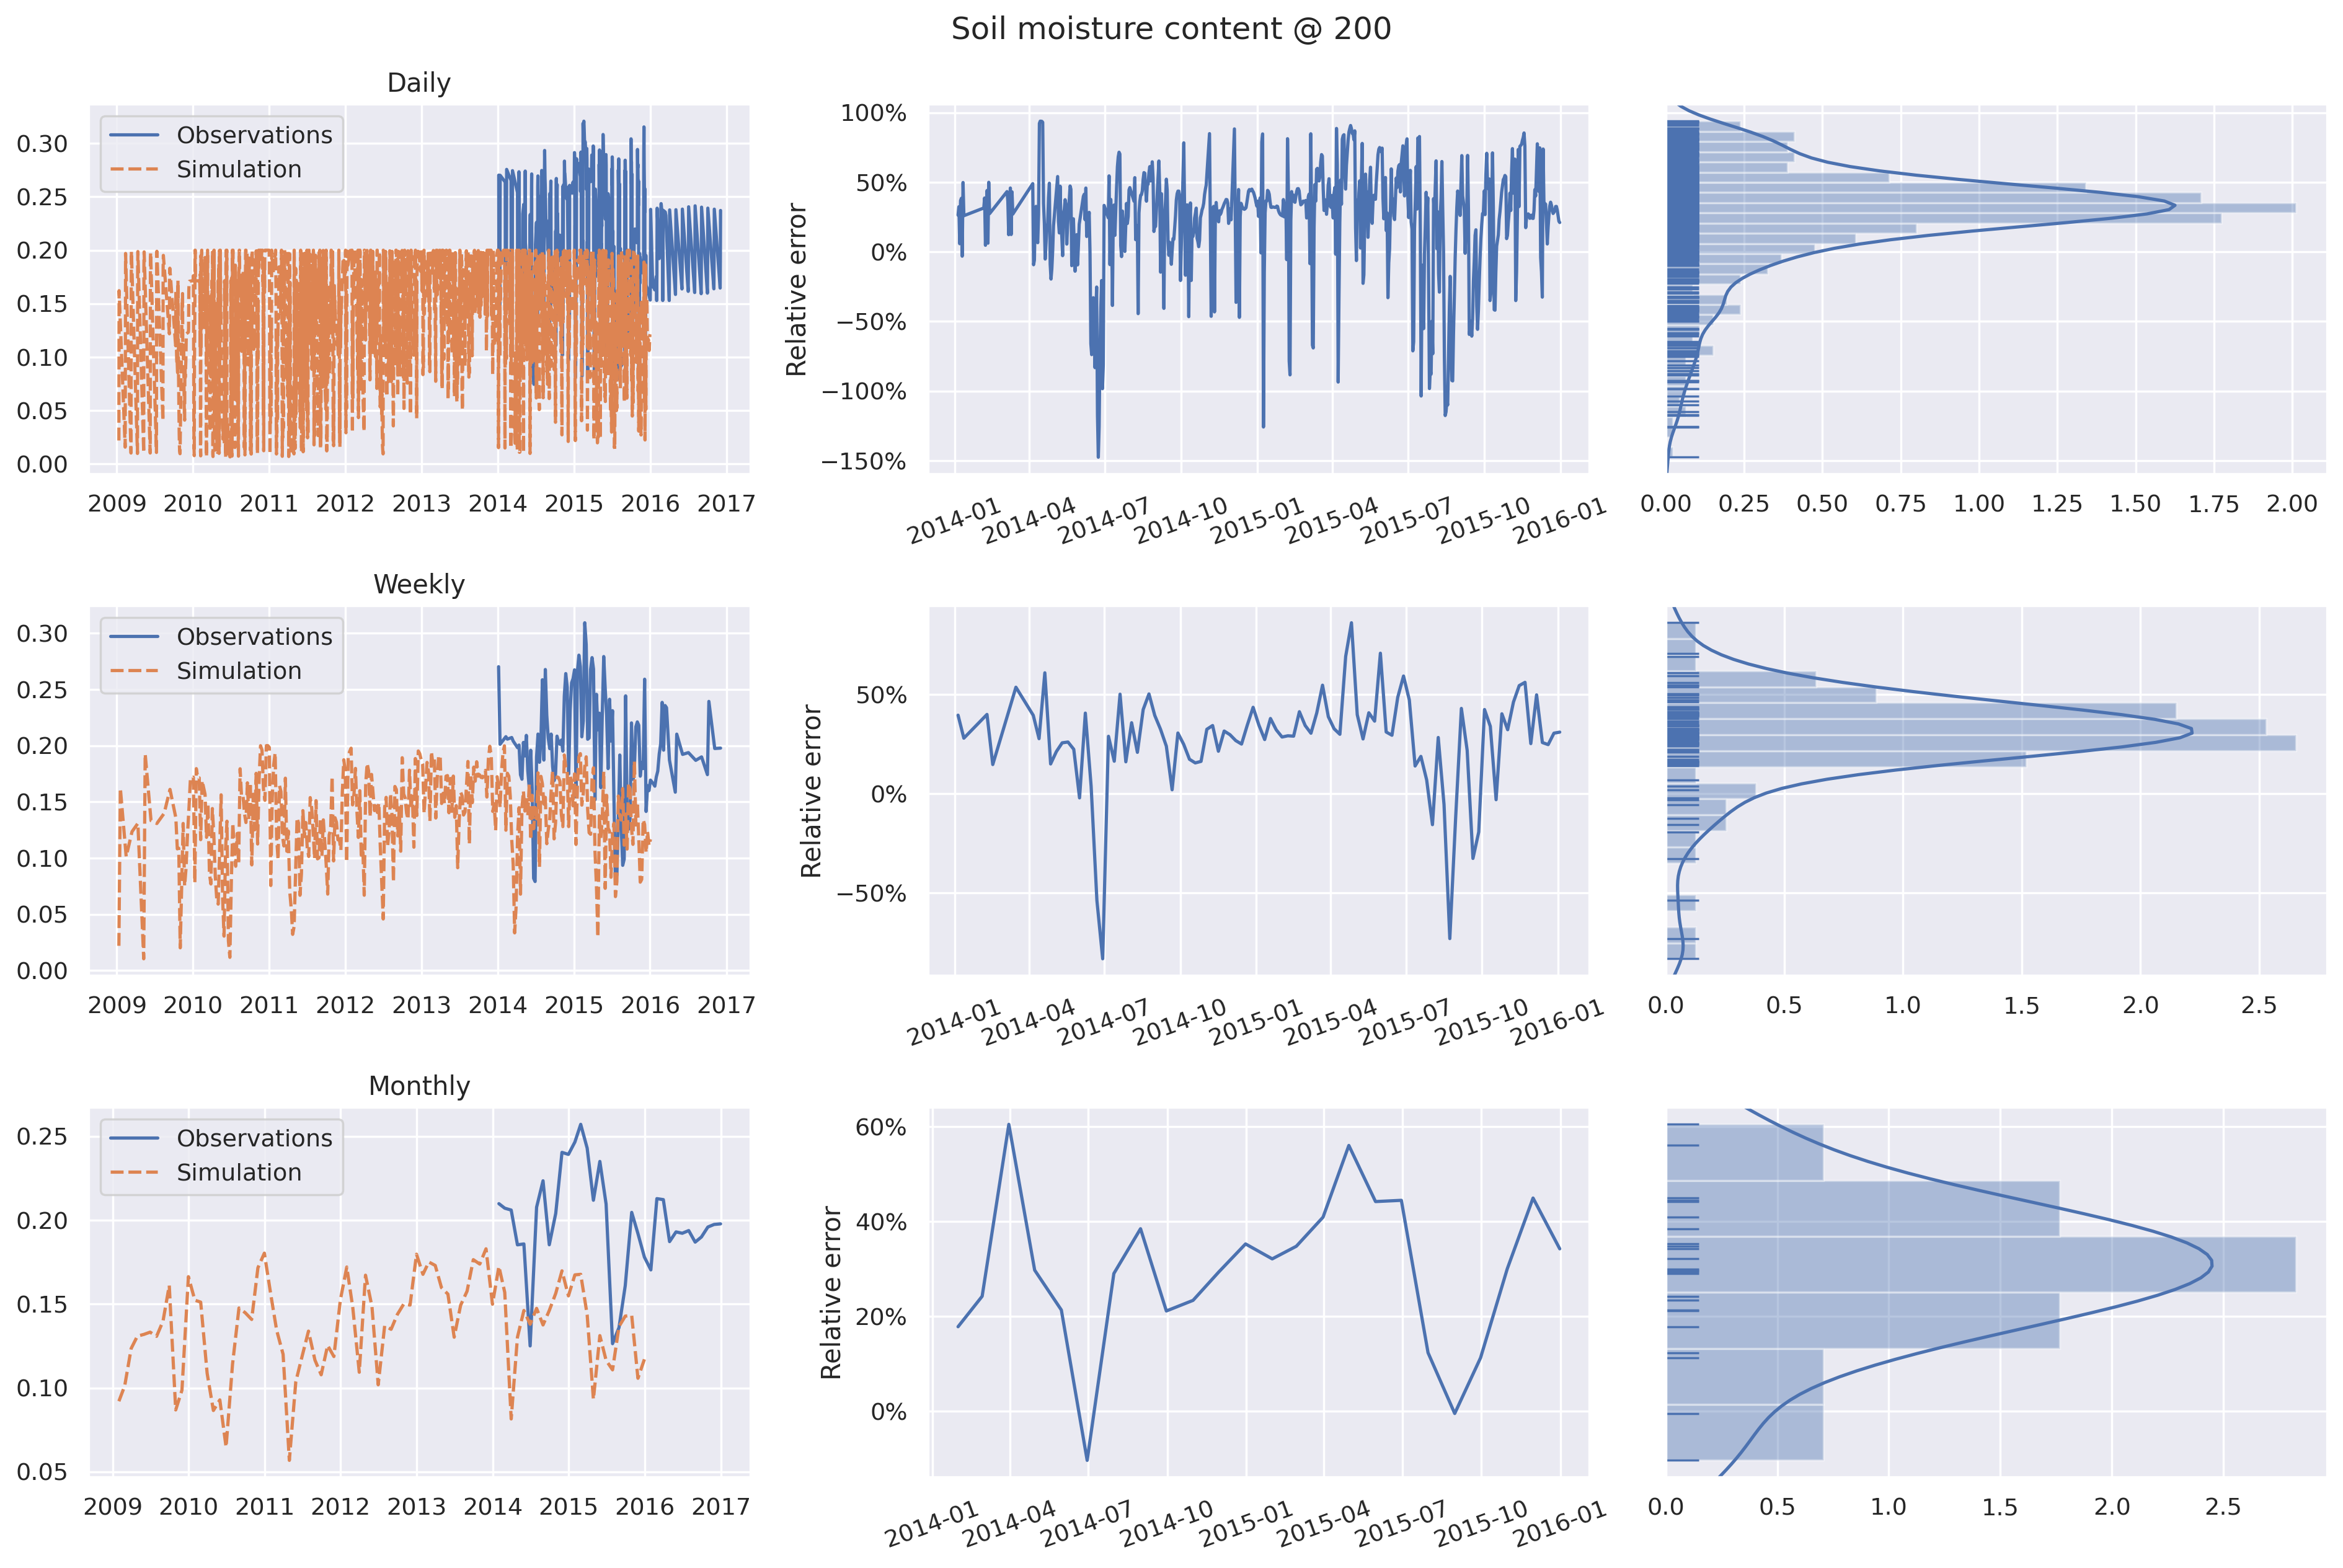

In [9]:
with tempfile.TemporaryDirectory() as tmpdir:
    
    print(f"Recommended value is: {recommendation.value}")
    print(f"Reported loss is: {recommendation.loss}")
    
    model = GEOtopCalibrationRun('data/inputs', exe='../../geotop/build/geotop')
    obs, sim = model.eval(tmpdir, **recommendation.kwargs)
    
    for depth in [20, 50, 200]:
        compare(obs[depth], sim[depth], name=f"Soil moisture content @ {depth}", rel=True)
        plt.show()